### Decision Tree Regression auf dem Ames Housing Price Data Set von kaggle.com

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. 

#### Versionsgeschichte

- 1.0 21.05.2023 Willi Hahn Initialversion
- 1.3 21.10.2023 Willi Hahn Datenvorbereitung nach Ames EDA.ipynb ausgelagert
    


In [1]:
# notwendige Bibliotheken importieren und konfigurieren
import numpy as np
import pandas as pd
_ = pd.set_option('display.max_columns', None) # damit mehr als 20 Spalten angezeigt werden.
#                                                    _ =  damit Objektausgabe unterdrückt wird.
pd.set_option('display.min_rows', 15) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
pd.set_option('display.max_rows', 500) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
import matplotlib.pyplot as plt #Plot Bibliothek
import seaborn as sns #importing Seaborn's for plots
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree # Ausgabe des Entscheidungsbaums
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from timeit import default_timer as timer

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool
output_notebook(resources=None, verbose=True, hide_banner=True)

scriptname='Ames Dec Tree.ipynb'
logtext=""
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    force=True,
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%Y-%m-%d %H:%M:%S",
    encoding='utf-8',
    filemode='a',
    filename="AllScripts.log" # Default ist append
)
logger = logging.getLogger()



In [2]:

# Daten einlesen
path = 'c:/myBox/Projekte/FHDW/python/Ames_Train_1_cleaned.csv'# für lokale Dateien
#path = 'https://github.com/WilliHahn/FHDW/raw/main/Ames_Train_1_cleaned.csv'
df = pd.read_csv(path, sep=',') 

# Originaldaten einlesen für Unersuchungen der Vorhersagen
#path = 'c:/myBox/Projekte/FHDW/Kurs DAML/Daten/AmesHousing.csv' # für lokale Dateien
#path = 'https://github.com/WilliHahn/FHDW/raw/main/AmesHousing.csv'
df_org= pd.read_csv(path, sep=',') 


In [3]:
# Trainings- und Testdaten aufteilen
TESTANTEIL = 0.25 # Split der Test- und Trainingsdaten
RANDOM_STATE=42
# Trennung von unabhängigen Variablen und abhängiger Zielvariable
y = df['SalePrice']
x = df.drop(['SalePrice'], axis = 1)
#x.head().T
#y.head().T

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=RANDOM_STATE)
dfx_test = pd.DataFrame(data=x_test, columns=x.columns) # Hilfe, um unskalierte Daten später in Bezug auf OrderNo zu zeigen
x_test.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
x_train.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
# und prüfen durch ansehen
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
#print (dfx_test.info(verbose=True))

(2017, 27) (2017,) (673, 27) (673,)


In [4]:
# Modellerstellung DecisionTreeRegressor
# GridSearchCV zur Bestimmung optimaler Hyperparameter
# für 29 Variablen
RANDOM_STATE=42
parameter_space = \
{
       "criterion":['squared_error'], #, 'squared_error', 'friedman_mse', 'poisson' absolute_error
       "max_features": [30], # int, float or {“auto”, “sqrt”, “log2”}, default=None
       "splitter":["best"],  #, "random" "best"
       "max_depth":[15], #) list(range(1, 20))
       "min_samples_split":[2 ], 
       "min_samples_leaf":[1], #list(range(1, 20),
       "max_leaf_nodes":[100],
       "random_state":[RANDOM_STATE]
   }

# für alle Variablen
parameter_space = \
{
       "criterion":['squared_error'], #, 'squared_error', 'friedman_mse',  absolute_error
       "max_features": [250], # int, float or {“auto”, “sqrt”, “log2”}, default=None
       "splitter":["best"],  #, "random" "best"
       "max_depth":[13,], #) list(range(1, 20))
       "min_samples_split":[2], 
       "min_samples_leaf":[1], 
       "max_leaf_nodes":[150],
       "random_state":[RANDOM_STATE]
   }

t0 = timer()
dt_test = GridSearchCV(DecisionTreeRegressor(random_state=42), parameter_space, 
                   cv=3, n_jobs=-1)
dt_test.fit(x_train, y_train)
t1 = timer()
print ('Laufzeit GridSearchCV = ', round(t1 - t0, 0), ' sec')
print("Best parameters:")
print(dt_test.best_params_)

CRITERION= dt_test.best_params_['criterion'] # poisson
MAX_DEPTH= dt_test.best_params_["max_depth"] # 8
MAX_FEATURES= dt_test.best_params_["max_features"] #250
MAX_LEAF_NODES= dt_test.best_params_["max_leaf_nodes"] # 50
MIN_SAMPLES_LEAF= dt_test.best_params_["min_samples_leaf"] # 22
MIN_SAMPLES_SPLIT= dt_test.best_params_["min_samples_split"] # 2
SPLITTER= dt_test.best_params_['splitter'] # 'BEST'



dt = DecisionTreeRegressor(criterion=CRITERION, max_depth=MAX_DEPTH, max_features=MAX_FEATURES, 
            max_leaf_nodes=MAX_LEAF_NODES, min_samples_leaf=MIN_SAMPLES_LEAF, min_samples_split=MIN_SAMPLES_SPLIT,
            splitter=SPLITTER)
dt.fit(x_train, y_train);
y_pred = dt.predict(x_test)


df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})

mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)
rmse = mean_squared_error(y_test,y_pred, squared=False) # squared=True gibt MSE zurück
print("RMSE",rmse)
r2 = r2_score(y_test,y_pred)
print('Model Score R2: ', r2)
adjusted_r2 = 1 - (1-r2)*(len(y_pred)-1)/(len(y_pred)-x_test.shape[1]-1)
print('Model Score R2 Adjusted: ', adjusted_r2)

logging.info(scriptname + ';' + " Standard scaled"+ "; Data Frame: " +str(df.shape[0])+ ";"+ str(df.shape[1])+ 
             "; Testanteil: "+ f'{TESTANTEIL:9.2f}'+ "; Seed: " + f'{RANDOM_STATE:9.0f}'+ ";")
logging.info(scriptname + ';' + CRITERION + 
             ";" + f'{MAX_DEPTH:3.0f}' + ";" + f'{MAX_FEATURES:3.0f}' + ";"+ f'{MAX_LEAF_NODES:3.0f}'+ 
             ";" + f'{MIN_SAMPLES_LEAF:3.0f}'+ ";" + SPLITTER+ ";" + f'{MIN_SAMPLES_SPLIT:3.0f}'+ ";")
logging.info(scriptname + '; MAE=' + f'{mae:9.0f}' + "; RMSE=" + f'{rmse:9.0f}'+ "; R2=" + f'{r2:9.4f}'+ "; R2 adj.="+ 
             f'{adjusted_r2:9.4f}'+ ";")


Laufzeit GridSearchCV =  3.0  sec
Best parameters:
{'criterion': 'squared_error', 'max_depth': 13, 'max_features': 250, 'max_leaf_nodes': 150, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
MAE = 22657.582384032346
RMSE 35096.56631190975
Model Score R2:  0.8095632235276085
Model Score R2 Adjusted:  0.8015914514892293


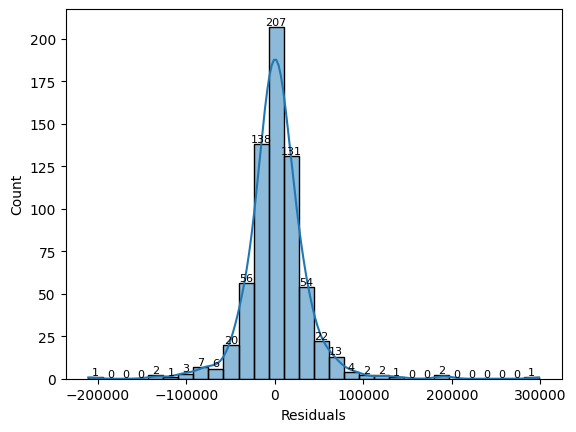

Vorhersagen mit Fehler > +-100000


,Actual,Predicted,Residual,SalePrice,Order,Bsmt Qual,Exter Qual,Fireplace Qu,Functional,Garage Area,Garage Qual,Gr Liv Area,HouseAge,TotalPorchSF,Kitchen AbvGr,Kitchen Qual,Land Contour,Lot Area,Lot Frontage,Lot Shape,Mas Vnr Area,Misc Val,NeighborhoodClass,Overall Cond,Pool QC,PosFeature_Adjacent,PosFeature_Near,Railroad_Adjacent,Railroad_Near,RemodelAge,Total Bsmt SF,TotalBathrooms
2269,625000,326516.666667,298483.333333,625000,2446,4.0,1,2.5,7,807.0,3,3627,11,437,1,1,3,35760,118.000000,2,1378.0,0,3,5,0,0.0,0.0,0.0,0.0,10,0.0,4.5
2086,330000,189458.730769,140541.269231,330000,2257,3.0,1,2.5,7,286.0,3,1502,9,0,1,1,3,9763,62.794969,2,239.0,0,2,5,0,0.0,0.0,0.0,0.0,9,72.0,2.5
324,375000,253415.000000,121585.000000,375000,350,4.0,1,3.0,7,564.0,3,2522,5,239,1,1,3,7296,28.000000,2,0.0,0,3,5,0,0.0,0.0,0.0,0.0,4,0.0,3.0
2520,415000,289850.000000,125150.000000,415000,2738,2.5,0,3.0,7,836.0,3,3672,71,796,1,1,3,19800,60.000000,3,0.0,0,1,8,0,0.0,0.0,0.0,0.0,16,0.0,3.5
1093,324000,219190.657143,104809.342857,324000,1181,3.0,1,3.0,7,473.0,3,1719,15,152,1,1,3,10846,32.000000,2,0.0,0,2,5,0,0.0,0.0,0.0,0.0,15,0.0,3.5
1506,591587,402583.333333,189003.666667,591587,1638,4.0,4,3.0,7,1110.0,4,2338,1,457,1,1,3,51974,52.000000,2,710.0,0,3,5,0,0.0,1.0,0.0,0.0,0,0.0,3.5
1509,392000,198618.583333,193381.416667,392000,1641,3.0,1,3.0,7,567.0,3,1419,0,140,1,1,1,8089,60.000000,3,0.0,0,3,6,0,0.0,0.0,0.0,0.0,0,0.0,3.0


In [5]:
# Vergleich der Verteilungen für wirklichen und vorhergesagten Verkaufspreisen
df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_pred,"Residual":y_test-y_pred})
#print('Actual test data vs predicted: \n', df_comparison)
#print(df_comparison.describe())
# Sind die die Residuen zwischen wirklichen und vorhergesagten Verkaufspreisen normalverteilt?
residuals = y_test - y_pred
y = sns.histplot(residuals, bins=30, stat='count', element="bars", kde=True)
_ = y.bar_label(y.containers[1], fontsize = 8)
_ = plt.xlabel('Residuals')
plt.show()

df_test=pd.concat([df_comparison,df_org], axis=1, join='inner') 
#print (df_test.info())
#df_test.loc[df_test["Order"] == 433].T  # Testdatensatz, um die Tooltips zu prüfen

print ("Vorhersagen mit Fehler > +-100000")
df_test.loc[df_test["Residual"] <= -100000  ] 
df_test.loc[df_test["Residual"] >= 100000  ] 

In [6]:
# Scatterplot für wahre Hauspreise gegen Vorhersagen, mit tool tips
# Explorative interaktive Graphik, um ungenaue Vorhersagen zu untersuchen.

source = ColumnDataSource(df_test)

hover = HoverTool(
        tooltips=[
            ("OrderNo", "@Order")
             , ("Sale Price Actual", "@Actual{0}")
             , ("Sale Price Predicted", "@Predicted{0}")
             , ("House Built", "@{Year Built}{0}")
             , ("House Remodel", "@{Year Remod/Add}{0}")
             , ("Lot Area", "@{Lot Area}{0}")
             , ("Liv Area above Ground", "@{Gr Liv Area}{0}")
             , ("Full Bath", "@{Full Bath}{0.0}")
             , ("Neighborhood", "@Neighborhood")
        ]
    )

p = figure(width=800, height=400, tools=[hover],
           title="Actual vs predicted Sale Price (see tool tip)", x_range=(0, 700000), y_range=(-200000, 200000),
           toolbar_location="right", toolbar_sticky=False)
p.add_tools(WheelZoomTool(), BoxZoomTool(), ResetTool())
p.xaxis.axis_label = 'Actual Sale Price'
p.yaxis.axis_label = 'Residual'
p.left[0].formatter.use_scientific = False
p.below[0].formatter.use_scientific = False
_ = p.circle('Actual', 'Residual', size=10, source=source)
_ = show(p)

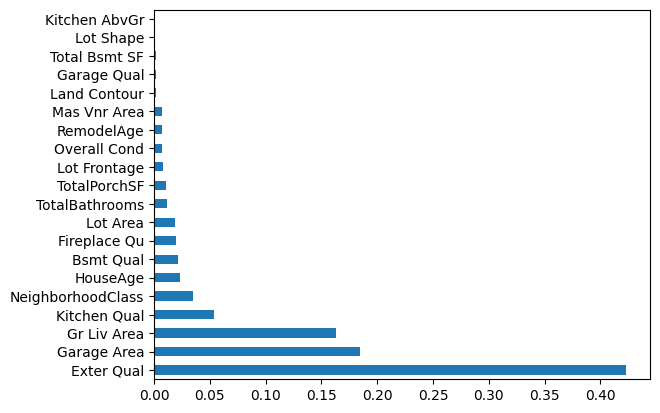

In [7]:
# Feature Importance
feat_importances = pd.Series(dt.feature_importances_, index=x_test.columns)
_ = feat_importances.nlargest(20).plot(kind='barh')

In [8]:
# Zelle Print Decision Tree

print(tree.export_text(dt, feature_names=x_test.columns))


|--- Exter Qual <= 0.50
|   |--- Gr Liv Area <= 1417.00
|   |   |--- HouseAge <= 55.50
|   |   |   |--- Gr Liv Area <= 1153.00
|   |   |   |   |--- Lot Area <= 2248.50
|   |   |   |   |   |--- value: [93610.62]
|   |   |   |   |--- Lot Area >  2248.50
|   |   |   |   |   |--- Bsmt Qual <= 1.00
|   |   |   |   |   |   |--- value: [85500.00]
|   |   |   |   |   |--- Bsmt Qual >  1.00
|   |   |   |   |   |   |--- Gr Liv Area <= 986.00
|   |   |   |   |   |   |   |--- RemodelAge <= 34.50
|   |   |   |   |   |   |   |   |--- value: [132208.36]
|   |   |   |   |   |   |   |--- RemodelAge >  34.50
|   |   |   |   |   |   |   |   |--- value: [120032.60]
|   |   |   |   |   |   |--- Gr Liv Area >  986.00
|   |   |   |   |   |   |   |--- Overall Cond <= 3.50
|   |   |   |   |   |   |   |   |--- value: [93466.67]
|   |   |   |   |   |   |   |--- Overall Cond >  3.50
|   |   |   |   |   |   |   |   |--- RemodelAge <= 40.50
|   |   |   |   |   |   |   |   |   |--- value: [146135.80]
|   |   |   |  